In [1]:
from hepmc import *
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Calculate transverse momentum of 4-vector
def pT(p):
    return np.sqrt(p[1]*p[1]+p[2]*p[2])

# Calculate angle between two 4-vectors
def angle(p, q):
    cos_angle = (p[1:].dot(q[1:]))/(p[0]*q[0])
    return np.arccos(cos_angle)

# Calculate pseudorapidity
def eta(p):
    pT = np.sqrt(p[:,1]*p[:,1]+p[:,2]*p[:,2])
    angle = np.arctan2(pT, p[:,-1])
    return -np.log(np.tan(.5*angle))

In [3]:
eeqqg = densities.ee_qq_1g(100., 5., .3)

In [4]:
rambo_mapping = phase_space.RamboOnDiet(100., 3)
mapped = phase_space.MappedDensity(eeqqg, rambo_mapping)

In [7]:
nodes = 100
nlearn = 1000
#x = np.linspace(0.001, .999, 100)
#y = np.linspace(0.001, .999, 100)
#mgrid = np.meshgrid(x, y)

xvals = np.random.random((nlearn, 5))
fvals = mapped.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(5)
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]
# train
params = basis.extreme_learning_train(xvals, log_vals, nodes)

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)

mapped.pot_gradient = surrogate_gradient

In [19]:
start = np.array([0.30527385, 0.59699739, 0.51985594, 0.57366659, 0.51096818])
sampler = hamiltonian.StaticSphericalHMC(mapped, .03, .03, 30, 30)
hmc_sample = sampler.sample(50000, start)

/net/theorie/home/tjansse2/studium/masterarbeit/hep-monte-carlo/src/hepmc/hamiltonian/hmc.py:57: RuntimeWarning: divide by zero encountered in true_divide
  state.pdf / self.p_dist.pdf(state.momentum))


Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.
Generated 35000 samples.
Generated 40000 samples.
Generated 45000 samples.
Generated 50000 samples.


In [20]:
momenta = rambo_mapping.map(hmc_sample.data)
p_1 = momenta[:,0:4]
p_2 = momenta[:,4:8]
p_3 = momenta[:,8:12]

pT_1 = np.sqrt(p_1[:,1]*p_1[:,1]+p_1[:,2]*p_1[:,2])
pT_2 = np.sqrt(p_2[:,1]*p_2[:,1]+p_2[:,2]*p_2[:,2])
pT_3 = np.sqrt(p_3[:,1]*p_3[:,1]+p_3[:,2]*p_3[:,2])
E_1 = p_1[:,0]
E_2 = p_2[:,0]
E_3 = p_3[:,0]
eta_1 = eta(p_1)
eta_2 = eta(p_2)
eta_3 = eta(p_3)

pT_dist = np.concatenate((pT_1, pT_2, pT_3))
E_dist = np.concatenate((E_1, E_2, E_3))
eta_dist = np.concatenate((eta_1, eta_2, eta_3))

(array([ 1703.,  2955.,  3196.,  5383.,  3210.,  2582.,  3035.,  3465.,
         3546.,  3797.,  3054.,  2764.,  2232.,  2419.,  5257.,  3367.,
         2997.,  2523.,  7152.,  4539.,  5306.,  4152.,  5485.,  9616.,
         6888.,  8626.,  6235.,  8407., 11446., 14663.]),
 array([ 5.06662829,  6.5625779 ,  8.05852751,  9.55447712, 11.05042673,
        12.54637634, 14.04232595, 15.53827557, 17.03422518, 18.53017479,
        20.0261244 , 21.52207401, 23.01802362, 24.51397323, 26.00992284,
        27.50587245, 29.00182206, 30.49777167, 31.99372129, 33.4896709 ,
        34.98562051, 36.48157012, 37.97751973, 39.47346934, 40.96941895,
        42.46536856, 43.96131817, 45.45726778, 46.95321739, 48.44916701,
        49.94511662]),
 <a list of 30 Patch objects>)

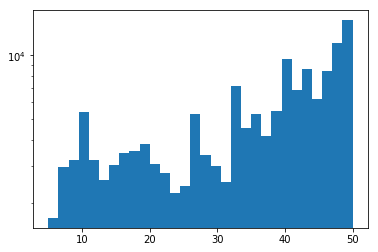

In [21]:
plt.figure()
plt.hist(E_dist, bins=30, log=True)

(array([4461., 4094., 4415., 8790., 3830., 3390., 4634., 8808., 5244.,
        3287., 4631., 4452., 3139., 7316., 3920., 3962., 6184., 4358.,
        5194., 6025., 4720., 4115., 5755., 4372., 5514., 5960., 6908.,
        4664., 4329., 3529.]),
 array([ 5.00879432,  6.50373305,  7.99867178,  9.49361051, 10.98854924,
        12.48348797, 13.9784267 , 15.47336542, 16.96830415, 18.46324288,
        19.95818161, 21.45312034, 22.94805907, 24.4429978 , 25.93793652,
        27.43287525, 28.92781398, 30.42275271, 31.91769144, 33.41263017,
        34.9075689 , 36.40250763, 37.89744635, 39.39238508, 40.88732381,
        42.38226254, 43.87720127, 45.37214   , 46.86707873, 48.36201745,
        49.85695618]),
 <a list of 30 Patch objects>)

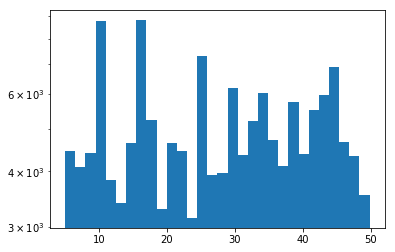

In [22]:
plt.figure()
plt.hist(pT_dist, bins=30, log=True)

(array([   22.,    34.,   153.,  3250.,   135.,   906.,  1333.,  2176.,
         3496.,  5708.,  8385.,  7933., 12028., 12994., 12536., 14832.,
        12343., 14881., 10218.,  7826.,  5573.,  4178.,  5357.,  2072.,
         1096.,   322.,    60.,    78.,    56.,    19.]),
 array([-2.52106012, -2.3539253 , -2.18679048, -2.01965566, -1.85252084,
        -1.68538602, -1.5182512 , -1.35111639, -1.18398157, -1.01684675,
        -0.84971193, -0.68257711, -0.51544229, -0.34830747, -0.18117265,
        -0.01403783,  0.15309699,  0.32023181,  0.48736663,  0.65450145,
         0.82163627,  0.98877109,  1.15590591,  1.32304073,  1.49017555,
         1.65731036,  1.82444518,  1.99158   ,  2.15871482,  2.32584964,
         2.49298446]),
 <a list of 30 Patch objects>)

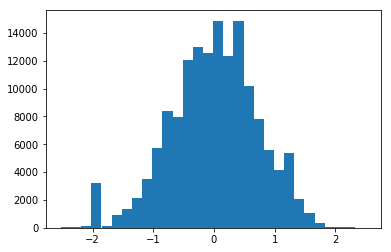

In [23]:
plt.figure()
plt.hist(eta_dist, bins=30)